# XGBoost Hyperparameter Tuning
In developing machine learning models, prediction accuracy is determined not only by the algorithm used but also by the underlying parameter settings. Hyperparameters play a crucial role because they determine how the model learns, how deep the decision tree is formed, and how quickly the learning process occurs. Proper adjustments can produce optimal model performance, while inappropriate settings can potentially lead to underfitting or overfitting. Therefore, exploring hyperparameters is crucial for building reliable models. By examining various optimization approaches, such as random search and probabilistic-based methods, it is possible to understand how changes in hyperparameter values contribute to improving model accuracy and stability.

# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier, plot_importance
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

# Load Dataset
The dataset is loaded into a DataFrame, containing sales information for various products (Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen) along with the Channel and Region categories for each customer.

In [2]:
df = pd.read_csv("C:/Users/LENOVO/Python/wholesale_customer_data.csv")

In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Selecting features and targets
Features (X) are selected from the product sales column, while targets (y) are from the Channel column to be predicted.

In [4]:
X = df.drop('Channel', axis=1)
y = df['Channel']

In [5]:
X.head()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,3,12669,9656,7561,214,2674,1338
1,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
3,3,13265,1196,4221,6404,507,1788
4,3,22615,5410,7198,3915,1777,5185


In [6]:
y.head()

0    2
1    2
2    2
3    1
4    2
Name: Channel, dtype: int64

In [7]:
y.unique()

array([2, 1])

# Convert labels to binary values
Channel labels are converted to binary format to fit the classification model: 2 → 0 and 1 → 1.

In [8]:
y = y.replace({2: 0, 1: 1})
y.head()

0    0
1    0
2    0
3    1
4    0
Name: Channel, dtype: int64

In [9]:
y.unique()

array([0, 1])

# Split data
The data is split into train and test data in an 80:20 ratio to evaluate the model's performance on previously unseen data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (352, 7), Test shape: (88, 7)


# Baseline Model (Default Parameters)

In [12]:
baseline = XGBClassifier(eval_metric='mlogloss', random_state=42)
baseline.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Prediction

In [13]:
y_pred_base = baseline.predict(X_test)

## Accuracy

In [14]:
base_acc = accuracy_score(y_test, y_pred_base)
print("Baseline Model Accuracy:", base_acc)

Baseline Model Accuracy: 0.9090909090909091


### Interpretation
* The baseline model yielded an accuracy of approximately 90.9% on the test data.
* With 88 samples, this means the model correctly predicted approximately 80 out of 88 cases.
* These results indicate that the default XGBoost configuration is quite good at recognizing patterns in the dataset, even before hyperparameter tuning.

## Classification report

In [15]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        23
           1       0.97      0.91      0.94        65

    accuracy                           0.91        88
   macro avg       0.87      0.91      0.89        88
weighted avg       0.92      0.91      0.91        88



### Interpretation
1. Accuracy
    - The model has an accuracy of 91%, meaning that out of 88 samples, approximately 80 cases were predicted correctly.
2. Class 0 (target 0 / Channel 2)
    - Precision 0.78 → Of all the model's predictions for class 0, 78% were indeed class 0.
    - Recall 0.91 → The model successfully captured 91% of all class 0 samples.
    - F1-score 0.84 → A good balance between precision and recall.
3. Class 1 (target 1 / Channel 1)
    - Precision 0.97 → Almost all class 1 predictions were correct.
    - Recall 0.91 → The model successfully detected 91% of class 1 samples.
    - F1-score 0.94 → Very good performance for this class.
4. Macro and weighted averages
    - Macro average (simple average between classes) showed balanced performance, with a precision of 0.87, a recall of 0.91, and an f1-score of 0.89.
    - Weighted average, taking into account support (the number of samples per class), yielded an f1-score of 0.91, which is close to overall accuracy.
5. General conclusions
    - The baseline model performed very well, especially for the majority class (class 1), and quite well for the minority class (class 0).
    - The model achieved a balance between precision and recall, resulting in fairly reliable predictions across both classes.

## Confusion matrix

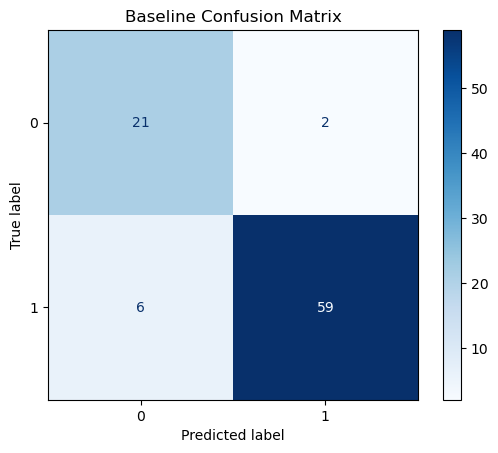

In [16]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_base)).plot(cmap="Blues")
plt.title("Baseline Confusion Matrix")
plt.show()

### Interpretation
* The model is better at detecting the majority class (1) than the minority class (0).
* The most dominant error is False Negatives (6 cases), where the model fails to recognize class 1 and instead predicts it as 0.
* However, the error distribution is still balanced and does not show extreme bias towards only one class.
* The baseline model has high accuracy (91%) and a fairly balanced prediction distribution.
* However, there are still weaknesses in precision for class 0 and recall for class 1, indicating room for improvement, especially in handling minority misclassifications and reducing FN.

## Feature Importance

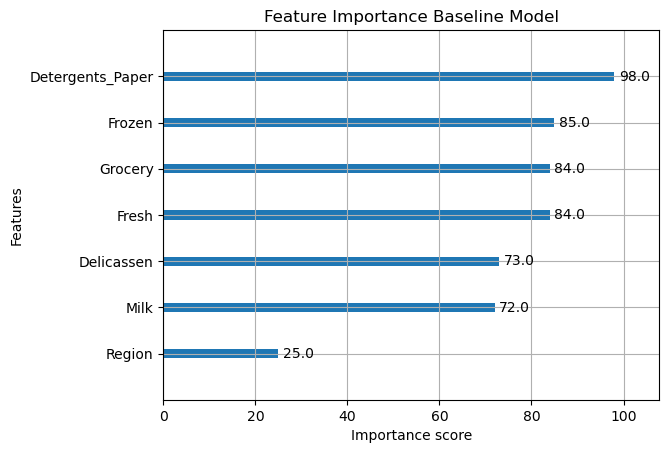

In [17]:
plot_importance(baseline)
plt.title("Feature Importance Baseline Model")
plt.show()

### Interpretation
1. Detergents_Paper (98.0)
    * This feature has the most influence on model predictions.
    * This means that purchasing patterns for paper and detergent products significantly determine the classification results.
2. Frozen (85.0), Grocery (84.0), Fresh (84.0)
    * These three features have almost the same level of importance.
    * Frozen products, daily necessities, and fresh products are all quite dominant in shaping the model's decisions.
3. Delicatessen (73.0) and Milk (72.0)
    * Still quite important, but their contribution is lower than the above groups.
    * This indicates that purchasing dairy and delicatessen products is only a supporting factor.
4. Region (25.0)
    * The feature with the lowest influence.
    * This means that customer location/region plays almost no role in the baseline model's decisions.
5. Conclusion
    * The baseline model relies heavily on the "Detergents_Paper" feature as the primary determinant.
    * Consumption-related features (Frozen, Grocery, Fresh) are quite strong, but not as strong as Detergents_Paper.
    * Geographic factors (Region) play a very small role → may be less relevant for prediction.

# Hyperparameter Tuning dengan Hyperopt (Bayesian)

## Defining parameters

In [18]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(50, 301, 50, dtype=int)),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5)
}

## Creating an objective function

In [19]:
def objective(params):
    model = XGBClassifier(
        eval_metric='mlogloss',
        random_state=42,
        **params
    )
    # cross-validation 3-fold
    acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=3, n_jobs=-1).mean()
    
    return {'loss': -acc, 'status': STATUS_OK}

## Hyperparameter tuning using the TPE (Tree-structured Parzen Estimator) algorithm

In [20]:
trials = Trials()
rng = np.random.default_rng(42)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials, rstate=rng)

100%|██████████| 30/30 [00:18<00:00,  1.60trial/s, best loss: -0.9260707904775701]


## Best hyperparameters

In [21]:
print("Best Hyperparameters:")
print(best)

Best Hyperparameters:
{'colsample_bytree': np.float64(0.9043819607728482), 'gamma': np.float64(0.4187050545704398), 'learning_rate': np.float64(0.1882802998714297), 'max_depth': np.int64(2), 'min_child_weight': np.int64(5), 'n_estimators': np.int64(1), 'reg_alpha': np.float64(2.763791522948141), 'reg_lambda': np.float64(1.8926403302469015), 'subsample': np.float64(0.8070489122109105)}


## Train Model with Best Hyperparameters

In [22]:
'''
best_params = {
    'max_depth': [3,4,5,6,7,8,9,10][best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': [50,100,150,200,250,300][best['n_estimators']],
    'gamma': best['gamma'],
    'min_child_weight': [1,2,3,4,5,6,7,8,9][best['min_child_weight']],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_lambda': best['reg_lambda'],
    'reg_alpha': best['reg_alpha']
}
'''
bayes_params = {
    'max_depth': [3,4,5,6,7,8,9,10][best.get('max_depth', 0)],
    'learning_rate': best.get('learning_rate', 0.1),
    'n_estimators': [50,100,150,200,250,300][best.get('n_estimators', 0)],
    'gamma': best.get('gamma', 0),
    'min_child_weight': [1,2,3,4,5,6,7,8,9][best.get('min_child_weight', 0)],
    'subsample': best.get('subsample', 1.0),
    'colsample_bytree': best.get('colsample_bytree', 1.0),
    'reg_lambda': best.get('reg_lambda', 1.0),
    'reg_alpha': best.get('reg_alpha', 0.0)
}


In [23]:
bayes_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    **bayes_params
)

In [24]:
bayes_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9043819607728482), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.4187050545704398), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.1882802998714297), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

## Prediction

In [25]:
y_pred_bayes = bayes_model.predict(X_test)

## Accuracy

In [26]:
bayes_acc = accuracy_score(y_test, y_pred_bayes)
print("Bayesian Model Accuracy:", bayes_acc)

Bayesian Model Accuracy: 0.8977272727272727


### Interpretation
* The model generated by Bayesian Optimization has an accuracy of approximately 89.8% on the test data.
* With 88 samples, this means the model correctly predicted approximately 79 out of 88 cases.
* This result is slightly lower than the baseline (90.9%), indicating that the best hyperparameter combination according to Bayesian Optimization does not always produce better generalization on the test data than the default XGBoost configuration.

## Classification report

In [27]:
print(classification_report(y_test, y_pred_bayes))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82        23
           1       0.97      0.89      0.93        65

    accuracy                           0.90        88
   macro avg       0.86      0.90      0.88        88
weighted avg       0.91      0.90      0.90        88



### Interpretation
1. Accuracy
    - The model has 90% accuracy, meaning that out of 88 samples, approximately 79 cases were predicted correctly.
2. Class 0 (target 0 / Channel 2)
    - Precision 0.75 → Of all the model's predictions for class 0, 75% were indeed class 0.
    - Recall 0.91 → The model successfully captured 91% of all class 0 samples.
    - F1-score 0.82 → Fairly good performance for this class, slightly lower than the baseline.
3. Class 1 (target 1 / Channel 1)
    - Precision 0.97 → Almost all class 1 predictions were correct.
    - Recall 0.89 → The model successfully detected 89% of class 1 samples, slightly lower than the baseline.
    - F1-score 0.93 → Very good performance, but slightly lower than the baseline.
4. Macro and weighted averages
    - Macro averages show the average between classes, with a precision of 0.86, a recall of 0.90, and an f1-score of 0.88.
    - Weighted averages take into account the support of each class, resulting in an f1-score of 0.90.
5. General conclusions
    - The Bayesian Optimization model performed quite well, with its ability to detect class 1 almost on par with the baseline.
    - However, for the minority class (class 0), the precision and f1-score were slightly lower than the baseline, resulting in a slight decrease in overall accuracy (90% vs. 91% of the baseline).

## Confusion matrix

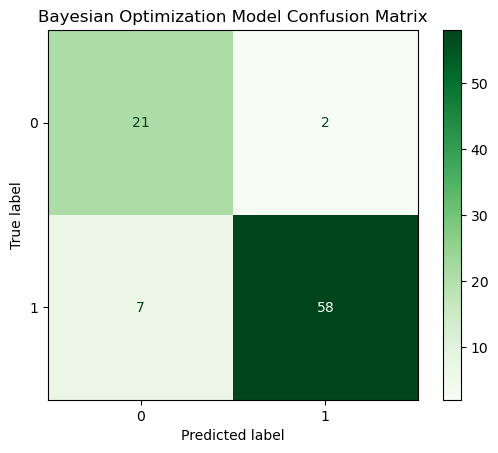

In [28]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_bayes)).plot(cmap="Greens")
plt.title("Bayesian Optimization Model Confusion Matrix")
plt.show()

### Interpretation
* The model is very good at recognizing the majority class (1) with high precision (97%).
* However, weaknesses appear in class 0, due to low precision (75%) due to a significant number of false negatives (7 cases).
* Compared to the baseline:
    - Recall for class 1 decreased slightly (from 91% → 89%).
    - Precision for class 0 also decreased (from 78% → 75%).
    - Overall, the Bayesian model is slightly more prone to errors in recognizing class 0.
* The Bayesian Optimization model achieved 90% accuracy, similar to the baseline, but:
    - Better precision for class 1 (still high at 97%).
    - Weaker precision for class 0 due to the higher FN.
    - This means the model prioritizes reducing prediction errors for class 1, but sacrifices some of its ability to correctly detect class 0.

## Feature Importance 

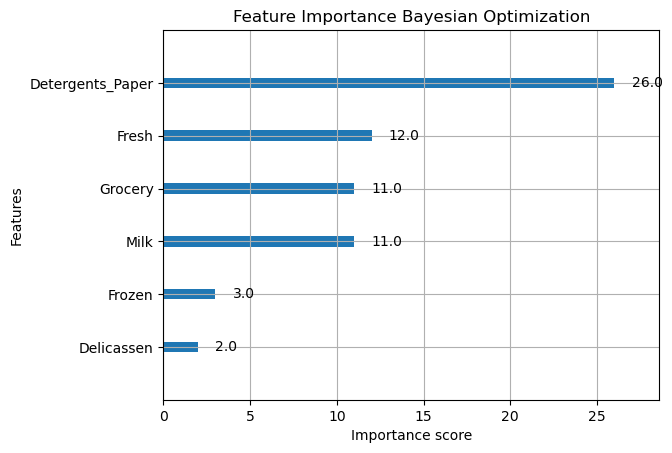

In [29]:
plot_importance(bayes_model)
plt.title("Feature Importance Bayesian Optimization")
plt.show()

### Interpretation
1. Detergents_Paper (26.0)
    * The most influential feature in the Bayesian model.
    * However, its score is much lower than the baseline (98.0).
    * This means that, although still dominant, the Bayesian model is more balanced in considering other features.
2. Fresh (12.0), Grocery (11.0), Milk (11.0)
    * These three features have a fairly similar influence and serve as the main support after Detergents_Paper.
    * This indicates that fresh consumption patterns, grocery shopping, and milk remain relevant in the prediction.
3. Frozen (3.0) and Delicassen (2.0)
    * They have almost no impact on the model.
    * The Bayesian model considers information from these two features to be less important.
4. Region
    * Does not appear in the list, meaning it is not used at all by the Bayesian model.
5. Key Differences with the Baseline
    * Baseline: Highly dependent on Detergents_Paper (almost 100) → risk of overfitting to a single feature.
    * Bayesian: More balanced; although Detergents_Paper remains dominant, its contribution is only about twice that of other features, making it more robust.
6. Implications
    * Bayesian optimization makes the model less biased towards a single feature.
    * This can improve generalizability, although the accuracy is slightly lower than the baseline.

## Learning Curve

In [30]:
train_sizes, train_scores, test_scores = learning_curve(bayes_model, X_train, 
                                                        y_train, cv=5, scoring='accuracy', n_jobs=-1)

In [31]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

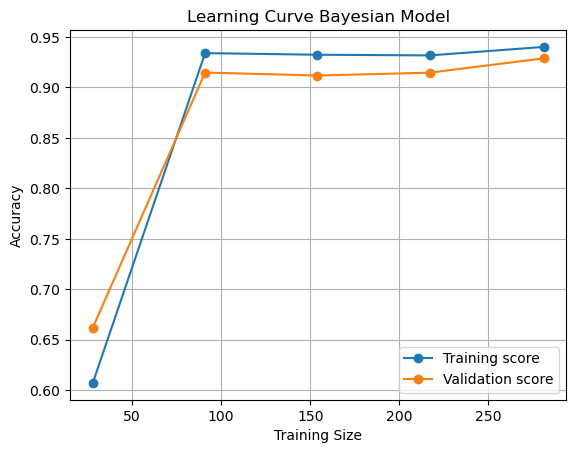

In [32]:
plt.plot(train_sizes, train_mean, label="Training score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation score", marker='o')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve Bayesian Model")
plt.legend()
plt.grid(True)
plt.show()

### Interpretation
1. Initial (Small Training Size, 30–50 samples)
    - The training score is very low (0.61).
    - The validation score is also low (0.66).
    - This is normal because the data is small, so the model is not yet able to learn patterns well.
2. Increased Training Size (90 samples)
    - The training score increases drastically to 0.94.
    - The validation score also increases significantly to 0.92.
    - This indicates that the model is starting to learn well and generalization is also quite good.
3. Medium Training Size (150–220 samples)
    - The training score decreases slightly (0.93), but remains stable.
    - The validation score also stabilizes around 0.91–0.92.
    - This pattern indicates a balance between bias and variance.
4. Large Training Size (270 samples)
    - The training score increases slightly again (0.94).
    - The validation score also increases, approaching 0.93.
    - This means that adding data has a positive effect, improving the model's generalization ability.
5. Conclusion
    - The Bayesian Optimization model for XGBoost provides high and stable performance on both training and validation data.
    - The gap between training and validation is very small (only 0.01–0.02) → minimal indication of overfitting.
    - The learning curve shows that adding data is still beneficial, even though the increase is relatively small (the model is already near optimal).

## Hyperopt Trials Visualization

In [33]:
bayes_results = pd.DataFrame([{**x['misc']['vals'], 'loss': x['result']['loss']} for x in trials.trials])

In [34]:
bayes_results.sort_values(by='loss', ascending=False).head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss
5,[0.9250198863250396],[2.307169927433259],[0.17329448321462293],[3],[6],[3],[2.2097169917622668],[0.8051205430874209],[0.8773636801323945],-0.911850
7,[0.6669925735866169],[3.642483496604307],[0.22389870711564028],[1],[3],[2],[3.740178864802004],[4.1504481618624025],[0.5321434316547746],-0.911850
18,[0.959337957982663],[3.4201481294366904],[0.20042794060555755],[5],[3],[5],[0.6403844796318592],[4.24927463194935],[0.6226067744404331],-0.911850
20,[0.8220714958501696],[1.8994056804852688],[0.11192654812881841],[2],[5],[1],[3.1520881659054916],[1.7172571870843885],[0.8034523560894572],-0.911850
17,[0.539010295434188],[1.1726609768193053],[0.054404204548523405],[6],[8],[0],[1.7534164663666645],[0.5154103306828078],[0.6624745156815548],-0.911874


In [35]:
bayes_results.sort_values(by='loss', ascending=False).tail()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss
25,[0.8574131025432652],[0.04865748090061783],[0.24172670320666578],[2],[5],[1],[2.6095617515002947],[1.761321654785428],[0.8159021390148128],-0.926047
24,[0.6112698672051794],[0.12033723098502236],[0.19230154249068276],[2],[1],[1],[2.6374512382981123],[1.8084100212815013],[0.7853545787318754],-0.926071
23,[0.9043819607728482],[0.4187050545704398],[0.1882802998714297],[2],[5],[1],[2.763791522948141],[1.8926403302469015],[0.8070489122109105],-0.926071
26,[0.9975341717569377],[0.5095101720708304],[0.1390293216933861],[2],[4],[1],[1.9896062223507487],[1.5552156972133993],[0.7606425485774708],-0.926071
28,[0.9985911713851607],[0.46747681306561417],[0.14367230966627295],[2],[4],[1],[3.4521487002288302],[1.3635545197892318],[0.706173128681292],-0.926071


In [36]:
for col in bayes_results.columns:
    bayes_results[col] = bayes_results[col].apply(lambda v: v[0] if isinstance(v, list) and len(v) > 0 else v)

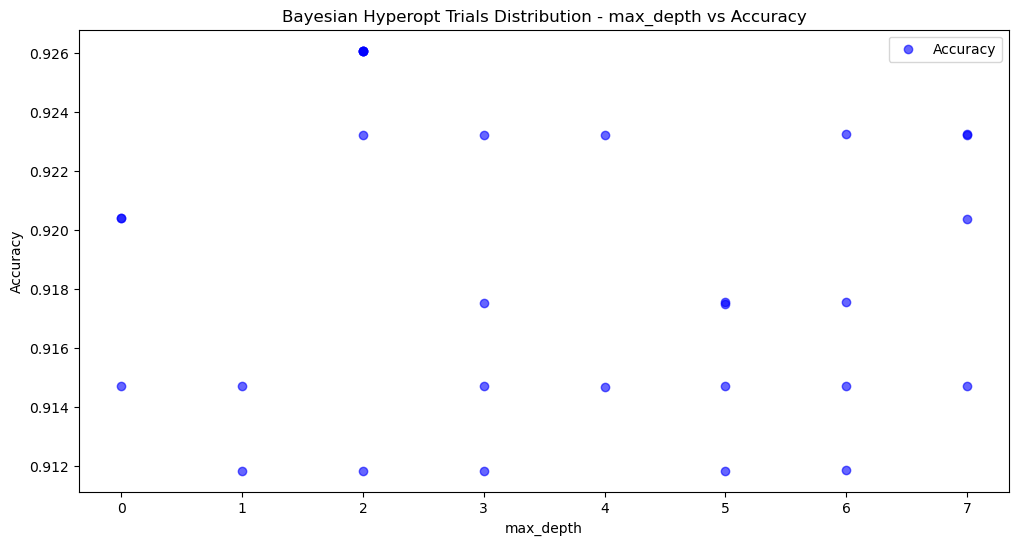

In [37]:
plt.figure(figsize=(12,6))
plt.scatter(bayes_results['max_depth'], -bayes_results['loss'], c='blue', alpha=0.6, label='Accuracy')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Bayesian Hyperopt Trials Distribution - max_depth vs Accuracy")
plt.legend()
plt.show()

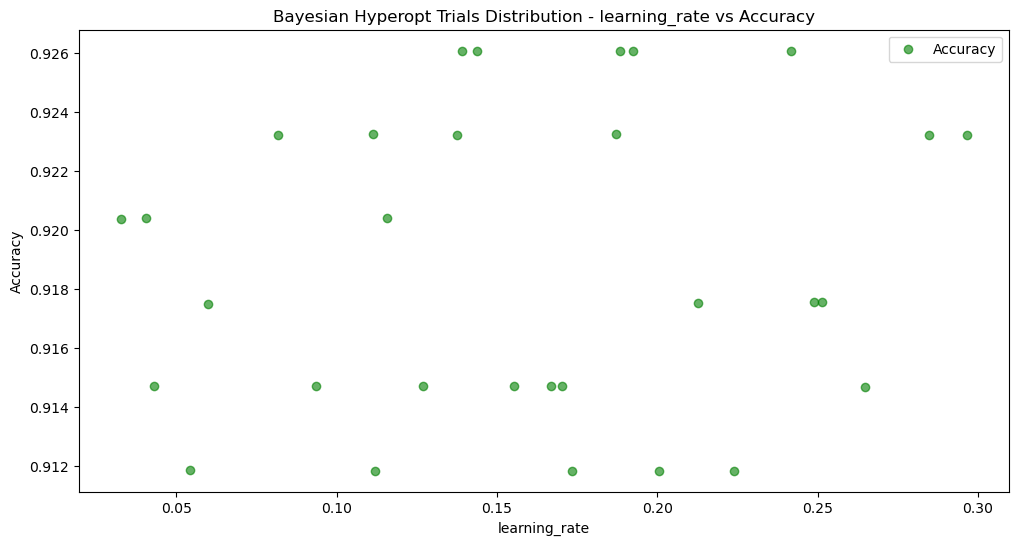

In [38]:
plt.figure(figsize=(12,6))
plt.scatter(bayes_results['learning_rate'], -bayes_results['loss'], c='green', alpha=0.6, label='Accuracy')
plt.xlabel("learning_rate")
plt.ylabel("Accuracy")
plt.title("Bayesian Hyperopt Trials Distribution - learning_rate vs Accuracy")
plt.legend()
plt.show()

# Hyperparameter Tuning with RandomizedSearchCV

## Defining parameters

In [39]:
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

In [40]:
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)

In [41]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,             # number of combinations tried
    scoring='accuracy',    # use f1_macro if dataset is unbalanced
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

## Training Model with Hyperparameters

In [42]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300],
                                        'reg_alpha': [0, 0.01, 0.1, 0.5, 1],
                                        'reg_lambda': [1, 1.5, 2, 3],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

## Best hyperparameters

In [43]:
random_model = random_search.best_estimator_

In [44]:
random_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:
print("Best hyperparameters:", random_search.best_params_)

Best hyperparameters: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}


## Prediction

In [46]:
y_pred_random = random_model.predict(X_test)

## Accuracy

In [47]:
random_acc = accuracy_score(y_test, y_pred_random)

In [48]:
print(f"Randomized Accuracy: {random_acc:.4f}")

Randomized Accuracy: 0.9091


### Interpretation
* The model generated by Randomized Search has an accuracy of approximately 90.9% on the test data.
* With 88 samples, this means the model correctly predicts approximately 80 out of 88 cases, the same as the baseline.
* These results indicate that Randomized Search is capable of finding hyperparameter combinations equivalent to the default XGBoost configuration, but does not provide a significant improvement in accuracy on this dataset.

## Classification report

In [49]:
random_report = classification_report(y_test, y_pred_random)

In [50]:
print("Classification Report:\n", random_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84        23
           1       0.97      0.91      0.94        65

    accuracy                           0.91        88
   macro avg       0.87      0.91      0.89        88
weighted avg       0.92      0.91      0.91        88



### Interpretation
1. Accuracy
    - The model has an accuracy of 91%, meaning that out of 88 samples, approximately 80 cases were predicted correctly.
2. Class 0 (target 0 / Channel 2)
    - Precision 0.78 → Of all the model's predictions for class 0, 78% were indeed class 0.
    - Recall 0.91 → The model successfully captured 91% of all class 0 samples.
    - F1-score 0.84 → A good balance between precision and recall.
3. Class 1 (target 1 / Channel 1)
    - Precision 0.97 → Almost all class 1 predictions were correct.
    - Recall 0.91 → The model successfully detected 91% of class 1 samples.
    - F1-score 0.94 → Very good performance for this class.
4. Macro and weighted averages
    - Macro average (simple average between classes) shows balanced performance, with a precision of 0.87, a recall of 0.91, and an f1-score of 0.89.
    - Weighted average takes into account the support of each class, resulting in an f1-score of 0.91, which is close to the overall accuracy.
5. General Conclusions
    - The Randomized Search model performs on par with the baseline, especially for the majority class (class 1) and quite well for the minority class (class 0).
    - This indicates that Randomized Search successfully found a hyperparameter combination equivalent to the default XGBoost configuration.

## Confusion matrix

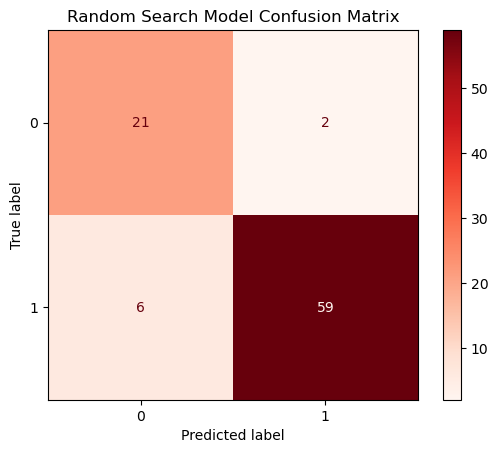

In [51]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_random)).plot(cmap="Reds")
plt.title("Random Search Model Confusion Matrix")
plt.show()

### Interpretation
* Both classes (0 & 1) performed equally well in recall (91%).
* Precision for class 1 was very high (97%), meaning that class 1 predictions were highly reliable.
* Compared to baseline and Bayesian Optimization:
    - Better than Bayesian because class 1 recall increased from 89% to 91%.
    - Similar to baseline in terms of TN, FP, and TP, only FN was slightly lower than Bayesian.
* The Random Search model provided the most stable results compared to baseline and Bayesian Optimization:
    - Recall was balanced across both classes (91%).
    - Precision for class 1 remained high (97%).
    - Fewer errors than the Bayesian model, especially in detecting class 1.
* In other words, Random Search provided the best overall performance because it maintained a balance in recall between the two classes without sacrificing precision.

## Feature Importance

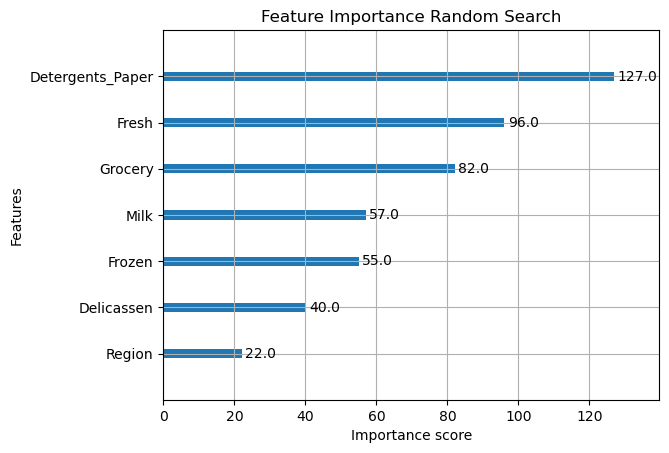

In [52]:
plot_importance(random_model)
plt.title("Feature Importance Random Search")
plt.show()

### Interpretation
1. Detergents_Paper (127.0)
    * The most dominant feature, even higher than the baseline (98.0) and Bayesian (26.0).
    * This means that the Random Search model relies heavily on this variable for predictions.
2. Fresh (96.0) and Grocery (82.0)
    * These two features rank second only to Detergents_Paper.
    * This indicates that shopping patterns for fresh and staple foods are also highly relevant.
    * Interestingly, the Fresh score is much higher than both the baseline and Bayesian scores, so Random Search considers Fresh as a key pillar.
3. Milk (57.0) and Frozen (55.0)
    * Both are mid-level, with significant contributions.
    * This indicates that milk and frozen food consumption still have an influence, although not as significant as the top three features.
4. Delicassen (40.0) and Region (22.0)
    * These have the smallest contribution, but are still considered relevant by the model.
    * Regions overlooked by Bayesian are still considered here (albeit small).
5. Conclusion
    * Random Search produces a more "even" model than the baseline, because it doesn't focus solely on Detergents_Paper.
    * However, the dominance of Detergents_Paper remains very high (127.0), so the model is still at risk of bias toward one key feature.
    * The advantage of this model over Bayesian is that it includes more features (including Frozen, Milk, and Region).
    * The disadvantage is that the model can be more complex, prone to overfitting, and more difficult to interpret because many features are considered important.

## Learning Curve

In [53]:
train_sizes, train_scores, test_scores = learning_curve(random_model, X_train, 
                                                        y_train, cv=5, scoring='accuracy', n_jobs=-1)

In [54]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

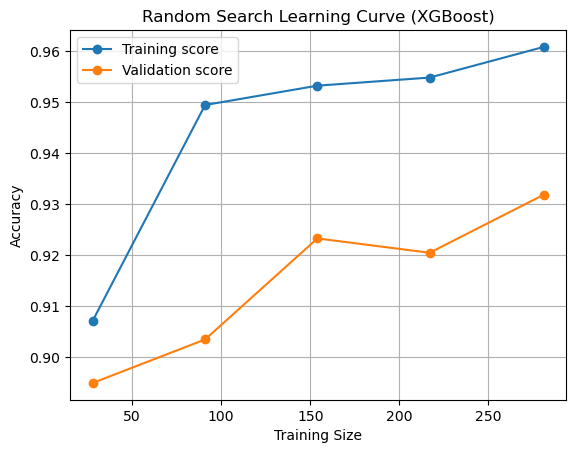

In [55]:
plt.plot(train_sizes, train_mean, label="Training score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation score", marker='o')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Random Search Learning Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

### Interpretation
1. Initial (Small Training Size, 30–50 samples)
    - The training score is relatively high (0.91).
    - The validation score is lower (0.89).
    - There is an initial gap, meaning the model adapts more quickly to the training data than it generalizes to the test data.
2. Increased Training Size (90–150 samples)
    - The training score increases significantly to 0.95.
    - The validation score also increases to 0.92.
    - This indicates the model is starting to stabilize and generalization is improving.
3. Medium Training Size (150–220 samples)
    - The training score increases slightly (0.95–0.955).
    - The validation score tends to stagnate around 0.92, even decreasing slightly.
    - This indicates that additional data has not significantly improved generalization.
4. Large Training Size (270 samples)
    - The training score reaches 0.961 (very high).
    - The validation score increased back to 0.93.
    - The gap between training and validation is quite clear (0.03), indicating there is still potential for mild overfitting.
5. Conclusion
    - The Random Search model achieved very high training accuracy (>0.96), but the validation score lagged slightly (0.93).
    - The training-validation gap is larger than Bayesian Optimization → indicating the model is more prone to overfitting.
    - Nevertheless, validation performance is quite good and stable, so the model is still suitable for use.

## Hyperopt Trials Visualization

In [56]:
random_results = pd.DataFrame([{**x['misc']['vals'], 'loss': x['result']['loss']} for x in trials.trials])

In [57]:
random_results.sort_values(by='loss', ascending=False).head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss
5,[0.9250198863250396],[2.307169927433259],[0.17329448321462293],[3],[6],[3],[2.2097169917622668],[0.8051205430874209],[0.8773636801323945],-0.911850
7,[0.6669925735866169],[3.642483496604307],[0.22389870711564028],[1],[3],[2],[3.740178864802004],[4.1504481618624025],[0.5321434316547746],-0.911850
18,[0.959337957982663],[3.4201481294366904],[0.20042794060555755],[5],[3],[5],[0.6403844796318592],[4.24927463194935],[0.6226067744404331],-0.911850
20,[0.8220714958501696],[1.8994056804852688],[0.11192654812881841],[2],[5],[1],[3.1520881659054916],[1.7172571870843885],[0.8034523560894572],-0.911850
17,[0.539010295434188],[1.1726609768193053],[0.054404204548523405],[6],[8],[0],[1.7534164663666645],[0.5154103306828078],[0.6624745156815548],-0.911874


In [58]:
random_results.sort_values(by='loss', ascending=False).tail()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss
25,[0.8574131025432652],[0.04865748090061783],[0.24172670320666578],[2],[5],[1],[2.6095617515002947],[1.761321654785428],[0.8159021390148128],-0.926047
24,[0.6112698672051794],[0.12033723098502236],[0.19230154249068276],[2],[1],[1],[2.6374512382981123],[1.8084100212815013],[0.7853545787318754],-0.926071
23,[0.9043819607728482],[0.4187050545704398],[0.1882802998714297],[2],[5],[1],[2.763791522948141],[1.8926403302469015],[0.8070489122109105],-0.926071
26,[0.9975341717569377],[0.5095101720708304],[0.1390293216933861],[2],[4],[1],[1.9896062223507487],[1.5552156972133993],[0.7606425485774708],-0.926071
28,[0.9985911713851607],[0.46747681306561417],[0.14367230966627295],[2],[4],[1],[3.4521487002288302],[1.3635545197892318],[0.706173128681292],-0.926071


In [59]:
for col in random_results.columns:
    random_results[col] = random_results[col].apply(lambda v: v[0] if isinstance(v, list) and len(v) > 0 else v)

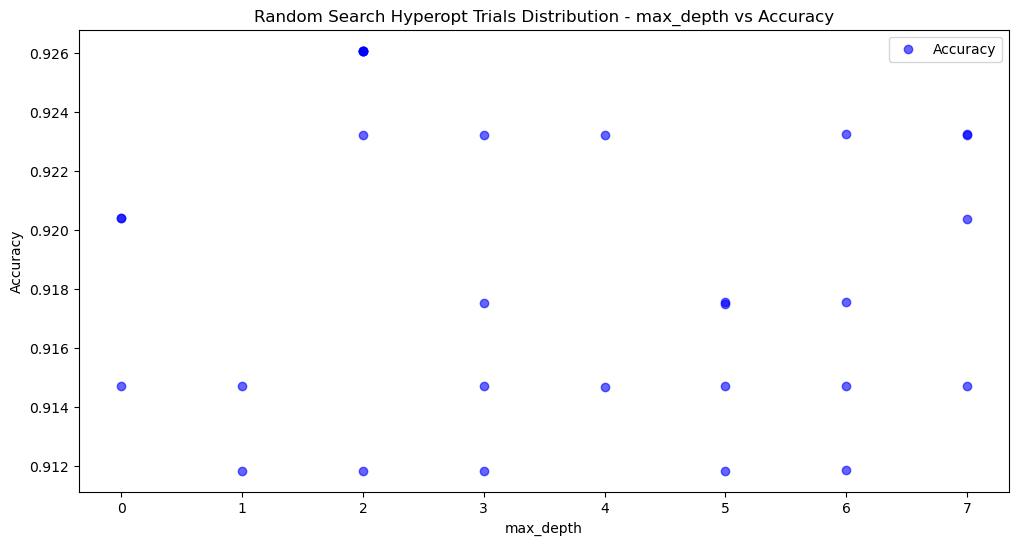

In [60]:
plt.figure(figsize=(12,6))
plt.scatter(random_results['max_depth'], -random_results['loss'], c='blue', alpha=0.6, label='Accuracy')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Random Search Hyperopt Trials Distribution - max_depth vs Accuracy")
plt.legend()
plt.show()

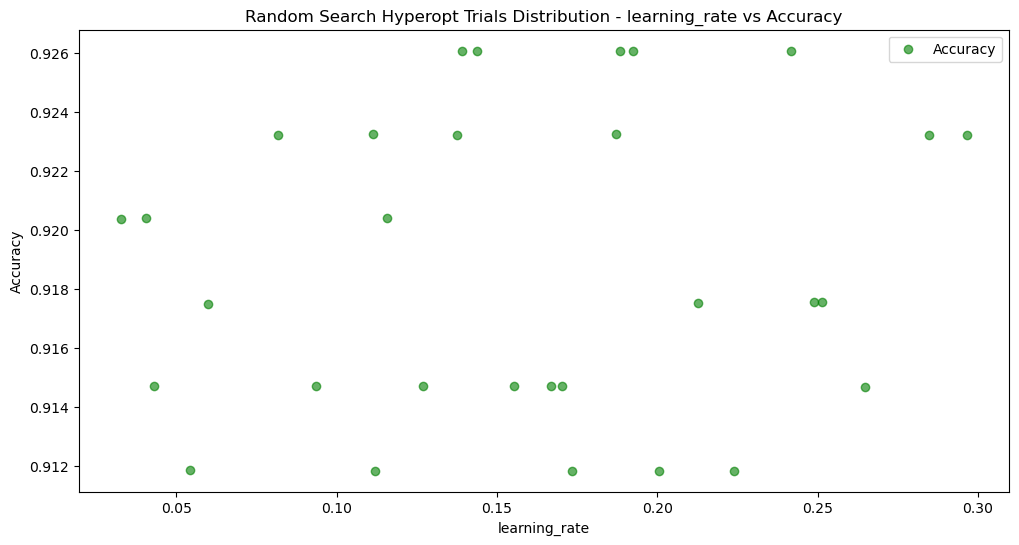

In [61]:
plt.figure(figsize=(12,6))
plt.scatter(random_results['learning_rate'], -random_results['loss'], c='green', alpha=0.6, label='Accuracy')
plt.xlabel("learning_rate")
plt.ylabel("Accuracy")
plt.title("Random Search Hyperopt Trials Distribution - learning_rate vs Accuracy")
plt.legend()
plt.show()

# Comparison Summary

## Model accuracy summary

In [62]:
summary_acc = pd.DataFrame({
    'Model': ['Baseline', 'Bayesian', 'Random'],
    'Accuracy': [round(base_acc,4), round(bayes_acc,4), round(random_acc,4)]
})

In [63]:
print("Model Comparison Summary:")
print(summary_acc.sort_values(by='Accuracy', ascending=False))

Model Comparison Summary:
      Model  Accuracy
0  Baseline    0.9091
2    Random    0.9091
1  Bayesian    0.8977


### Interpretation
* Baseline (0.9091 / 90.91%) → The initial model performed quite well, providing accuracy above 90%.
* Random Search (0.9091 / 90.91%) → Similar to the baseline, no significant improvement, but still maintained stable performance.
* Bayesian Optimization (0.8977 / 89.77%) → Slight decrease compared to the baseline and random search. This indicates that Bayesian optimization did not improve accuracy, but rather decreased it.
* The models with the best accuracy were Baseline and Random Search (both 90.91%).
* Bayesian Optimization performed lower (89.77%), making it less optimal in this case.
* Overall, Random Search can be chosen as the best alternative, as it provides consistent results without decreasing accuracy.

In [64]:
summary_pred = pd.DataFrame({
    'Target': y_test.reset_index(drop=True),
    'Baseline': y_pred_base,
    'Bayesian': y_pred_bayes,
    'Random': y_pred_random
})

## Ringkasan perbandingan target vs prediksi setiap model

In [65]:
summary_pred

,Target,Baseline,Bayesian,Random
0,1,1,1,1
1,1,1,1,1
2,0,0,0,0
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
83,0,0,0,0
84,1,1,1,1
85,0,0,0,0
86,1,1,1,1


| Model             | TN | FP | FN | TP | Recall Class 0 | Precision Class 0 | Recall Class 1 | Precision Class 1 | Key Notes |
| ----------------- | -- | -- | -- | -- | -------------- | ----------------- | -------------- | ----------------- | --------------------------------------------------------- |
| **Baseline**      | 21 | 2  | 6  | 59 | 91%            | 78%               | 91%            | 97%               | Initial performance is quite balanced. |
| **Bayesian Opt.** | 21 | 2 | 7 | 58 | 91% | 75% | 89% | 97% | Slightly worse, especially with a decrease in class 1 recall. |
| **Random Search** | 21 | 2 | 6 | 59 | 91% | 78% | 91% | 97% | Similar to baseline, but better than Bayesian. |


# Accuracy comparison visualization

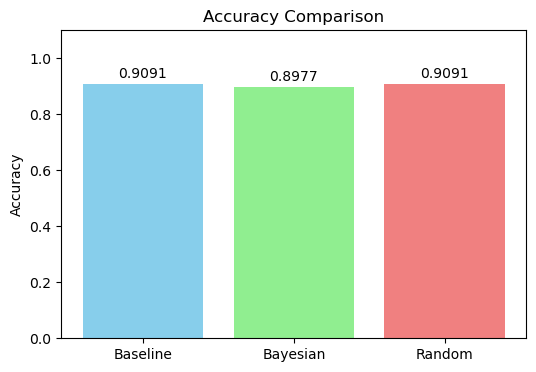

In [66]:
plt.figure(figsize=(6,4))
plt.bar(summary_acc['Model'], summary_acc['Accuracy'], color=['skyblue','lightgreen', 'lightcoral'])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
for i, acc in enumerate(summary_acc['Accuracy']):
    plt.text(i, acc + 0.01, str(acc), ha='center', va='bottom', fontsize=10)
plt.ylim(0, 1.1)
plt.show()

# Conclusion
The tests conducted showed that hyperparameter tuning significantly impacted model performance. Each parameter combination had different consequences, both in terms of accuracy, stability, and generalizability to new data. The analysis results showed that finding the optimal configuration resulted in a model with a better balance between training and validation data, while minimizing the potential for prediction errors. Thus, hyperparameter tuning is not simply a technical process, but an essential strategy to ensure that the model built accurately represents data patterns and is effective in real-world applications.

# Thank You